In [6]:
# pca_single_time_reduced.ipynb
# Noah Stiegler
# 7/2/24
# Exploring how the PCA works for just a single time of a single source
# And with snr, power, incoherent power all lumped together

In [7]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

(1800, 3)


<Axes: xlabel='signal_frequency', ylabel='signal_drift_rate'>

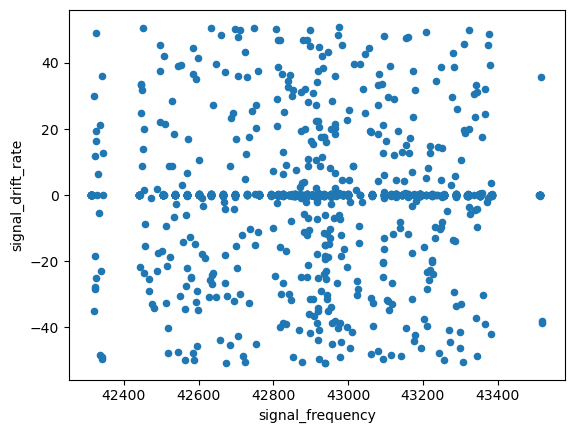

In [9]:
# Keep columns I think might be important
columns_we_care_about = [
    "signal_frequency",
    "signal_drift_rate",
	"signal_power"]

# Take only data from a single source
first_source = coherent["source_name"][0]
indices_of_first_source = coherent["source_name"] == first_source
first_time = coherent["tstart"][0]
indices_of_first_time = coherent["tstart"] == first_time
indices_of_data = indices_of_first_source & indices_of_first_time
data = coherent[indices_of_data][columns_we_care_about]
print(data.shape)

data.plot.scatter("signal_frequency", "signal_drift_rate")

In [10]:
# Normalize (standardize) the data to have mean 0 and std dev of 1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data.shape)

(1800, 3)


In [11]:
# Create PCA object
pca = PCA()

# Fit PCA to the data
pca.fit(scaled_data)

PCA()

In [12]:
# Get the coordinates of the original data in the transformed space
principal_components = pca.transform(scaled_data)  # Use scaled_data if standardized, df if not standardized
print(principal_components.shape)

(1800, 3)


In [13]:
# See how much of the variance in the data is explained by
# each principal component
explained_variance = pca.explained_variance_ratio_

In [14]:
# See what the components of the PCAs are
components = pca.components_
columns = data.columns
precision = 4
for i, component in enumerate(components):
    to_print = f"PC{i} = {round(component[0], precision)}x({columns[0]})"
    for j in range(1, len(columns)):
        to_print += f" + {round(component[j], precision)}x({columns[j]})"

    print(to_print)

PC0 = 0.6938x(signal_frequency) + 0.2057x(signal_drift_rate) + 0.6902x(signal_power)
PC1 = 0.1267x(signal_frequency) + -0.9783x(signal_drift_rate) + 0.1641x(signal_power)
PC2 = -0.7089x(signal_frequency) + 0.0264x(signal_drift_rate) + 0.7048x(signal_power)


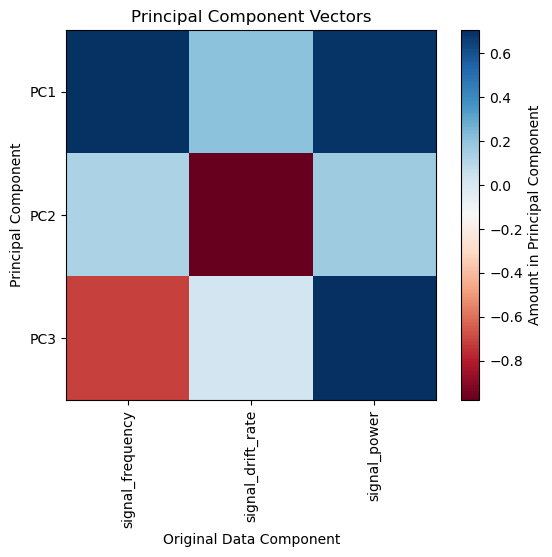

In [15]:
plt.imshow(components, cmap='RdBu')
plt.title("Principal Component Vectors")
plt.xlabel("Original Data Component")
plt.ylabel("Principal Component")

# Colorbar
cbar = plt.colorbar(label="Amount in Principal Component")

# Change ticks
num_components = len(components)
tick_nums = np.arange(num_components)
plt.gca().set_xticks(tick_nums)
plt.gca().set_yticks(tick_nums)
PC_labels = [f"PC{i}" for i in range(1, num_components + 1)]
plt.gca().set_xticklabels(columns, rotation='vertical')
plt.gca().set_yticklabels(PC_labels)

plt.show()

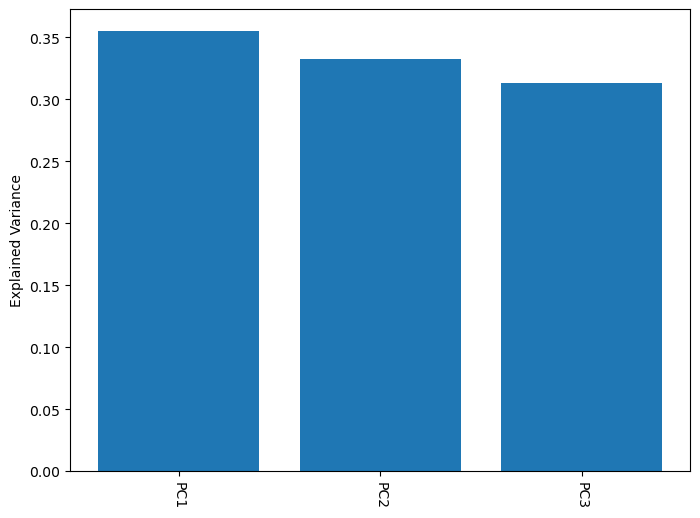

In [16]:
# Plot explained variance
fig, ax = plt.subplots(figsize=(8, 6))
xlabels = [f"PC{i}" for i in range(1, len(explained_variance) + 1)]
ax.bar(xlabels, explained_variance)
plt.xticks(rotation=-90) 
plt.ylabel("Explained Variance")
plt.show()

Text(0, 0.5, 'Variance Explained by Components')

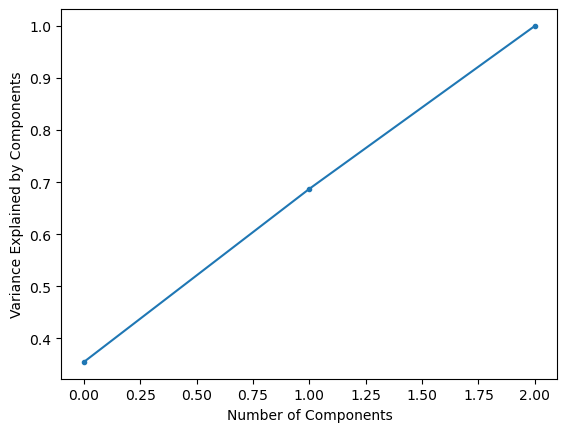

In [17]:
# Plot cumulative variance with number of columns
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(len(data.columns)), cumulative_variance, marker='.')
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained by Components")

In [18]:
def plot_first_2_pcs(color_feature=None):
    if color_feature != None:
        plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".", c=data[color_feature])
        plt.colorbar(label=color_feature)
    else:
        plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".")

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("First 2 PCs")
    plt.show()

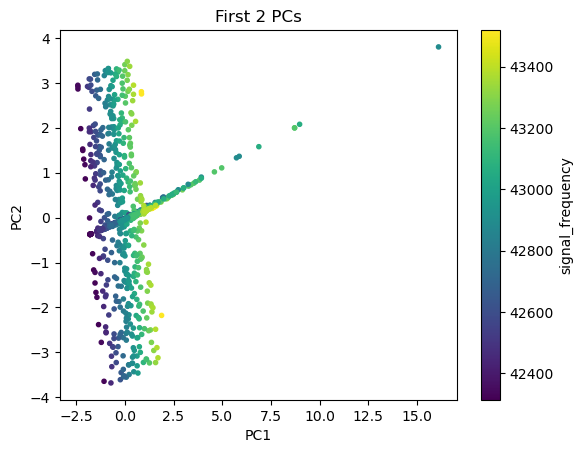

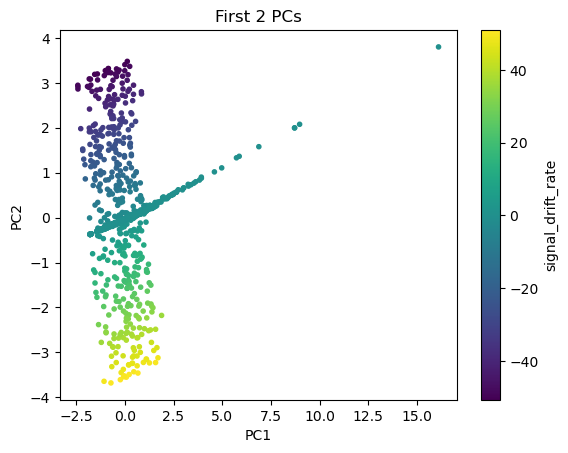

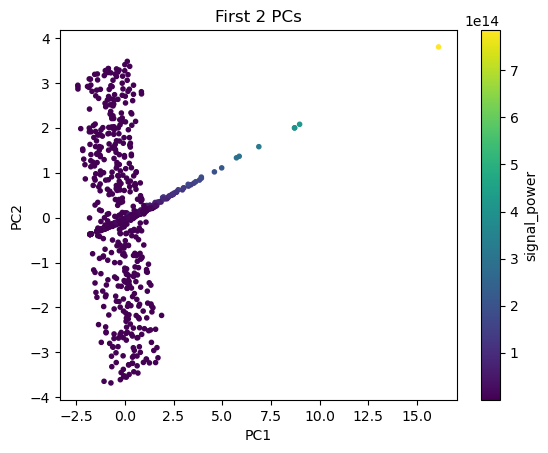

In [19]:
for column in columns:
    plot_first_2_pcs(color_feature=column)

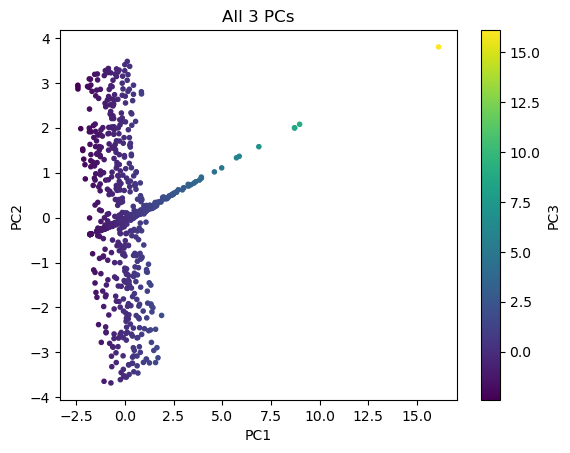

In [23]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], marker=".", c=principal_components[:, 0])
plt.colorbar(label="PC3")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("All 3 PCs")
plt.show()

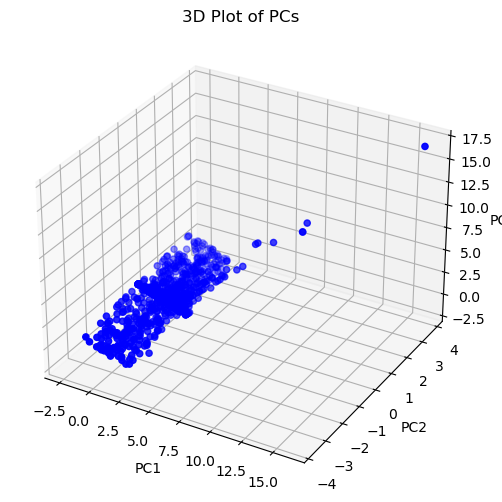

In [32]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points as a 3D scatter plot
PC = [principal_components[:, i] for i in range(principal_components.shape[1])]
ax.scatter(PC[0], PC[1], PC[2], c='blue', marker='o')

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Plot of PCs')

# Show plot
plt.show()